# Project 3 Codebook

## Topic: Spatial Analysis of Exposure to Respiratory Hazards and School Performance in Riverside, California.

#### Data and Time Frame for Analysis
1. [EJScreen data - 2020](https://open.quiltdata.com/b/spatial-ucr/tree/epa/ejscreen/)
2. [NCES/Districts - 2018/2019](https://open.quiltdata.com/b/spatial-ucr/tree/nces/schools/)
3. [ACS- 2018](https://open.quiltdata.com/b/spatial-ucr/tree/census/acs/)
4. [SEDA- Standardized test scores administered in 3rd through 8 th grade in mathematics and Reading Language Arts (RLA) over the 2008-09 through 2017-18 school years](https://edopportunity.org/)

#### TASKS
- Import software
- Retrieve Data from all four data sources.
- Create GeoDataframes for EPA EJScreen and SEDA using ACS and NCES geometry.
- Subset data for Riverside specific EJScreen respiratory hazards index and schooling outcomes for the Riverside Unified School District using SEDA. 
- Overlay RUSD schooling outcomes and EJ Respiratory Hazards Index.


### 1: Download software 

In [1]:
# Import software

import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt 
import contextily as ctx
import numpy as np
import quilt3
from geopandas_view import view 
import libpysal as lps
import seaborn as sns
import tobler as tob
plt.rcParams['figure.figsize'] = [8, 8]


###  2: Retrieve and Adjust Data

#### 2.1 Environmental Justice Screen Data From EPA

In [2]:
# Retrieve EPA EJ Screen data from UCR CGS Quilt Bucket

b = quilt3.Bucket("s3://spatial-ucr")
b.fetch("epa/ejscreen/ejscreen_2020.parquet", "./ejscreen_2020.parquet"), # Might be a good idea to get 2018
ej = pd.read_parquet('ejscreen_2020.parquet')
ej.head()

100%|██████████| 146M/146M [00:04<00:00, 31.5MB/s] 


,OBJECTID,ID,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,MINORPOP,MINORPCT,LOWINCOME,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,1,010010201001,636,636,418,294,294,104,0.163522,245,...,36.8 ppb (15%ile),54%ile,9.69 ug/m3 (86%ile),52%ile,4259428.0,28435.0,0,0,13443.155206,6.040790e+06
1,2,010010201002,1287,1287,885,471,485,278,0.216006,210,...,36.8 ppb (15%ile),36%ile,9.69 ug/m3 (86%ile),28%ile,5558385.0,0.0,0,0,11917.089598,7.834160e+06
2,3,010010202001,810,802,568,322,370,548,0.676543,402,...,36.8 ppb (16%ile),70%ile,9.71 ug/m3 (86%ile),72%ile,2058380.0,0.0,0,0,7770.915121,2.900774e+06
3,4,010010202002,1218,1016,875,397,482,670,0.550082,400,...,36.8 ppb (16%ile),67%ile,9.71 ug/m3 (86%ile),69%ile,1267299.0,5669.0,0,0,6506.804784,1.793332e+06
4,5,010010203001,2641,2641,1849,948,1049,899,0.340401,814,...,36.9 ppb (16%ile),51%ile,9.75 ug/m3 (86%ile),48%ile,3866515.0,9054.0,0,0,11070.367848,5.461602e+06


In [3]:
# Rename EJ column to state GEOID
ej.rename(columns = {'ID' : 'GEOID'}, inplace = True)
# ej.head()

In [4]:
ej.columns

Index(['OBJECTID', 'GEOID', 'ACSTOTPOP', 'ACSIPOVBAS', 'ACSEDUCBAS',
       'ACSTOTHH', 'ACSTOTHU', 'MINORPOP', 'MINORPCT', 'LOWINCOME',
       ...
       'T_OZONE', 'T_OZONE_D2', 'T_PM25', 'T_PM25_D2', 'AREALAND', 'AREAWATER',
       'NPL_CNT', 'TSDF_CNT', 'Shape_Length', 'Shape_Area'],
      dtype='object', length=141)

In [5]:
type(ej)

pandas.core.frame.DataFrame

Note: EPA EJ Screen is not a geodataframe so we need ACS census blockgroup data to convert it into geodataframe.

In [6]:
# Download USA Census block groups from the 2018 ACS via Quilt
geoms = gpd.read_parquet('s3://spatial-ucr/census/acs/acs_2018_bg.parquet')
geoms.head()

,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,n_nonhisp_black_persons,...,p_female_headed_families,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,p_native_persons,p_asian_persons,p_hawaiian_persons,p_asian_indian_persons,p_veterans,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
020130001003,287.0,213.0,26.0,1164.0,154.0,218.0,280.0,29.0,234.0,4.0,...,10.357143,16.846652,0.287977,6.839453,41.324694,23.182145,1.007919,23.182145,4.463643,"MULTIPOLYGON (((-159.91033 54.81417, -159.9057..."
020160001001,175.0,157.0,25.0,807.0,64.0,146.0,127.0,10.0,203.0,41.0,...,7.874016,20.949432,4.231166,11.764706,48.710010,9.907121,3.405573,9.907121,12.074303,"MULTIPOLYGON (((179.38874 51.94192, 179.40456 ..."
020160002001,320.0,224.0,21.0,1884.0,256.0,302.0,248.0,3.0,270.0,91.0,...,1.209677,12.517385,4.218822,12.888271,1.205378,66.759388,0.834492,66.759388,2.781641,"MULTIPOLYGON (((-167.24289 53.85467, -167.2370..."
020160002002,468.0,335.0,29.0,2220.0,304.0,435.0,341.0,6.0,916.0,114.0,...,1.759531,34.908537,4.344512,15.472561,5.182927,33.574695,3.696646,33.574695,3.620427,"MULTIPOLYGON (((-167.90386 53.22286, -167.8910..."
020200001011,75.0,79.0,37.0,404.0,49.0,73.0,63.0,0.0,351.0,4.0,...,0.000000,75.646552,0.862069,0.000000,12.715517,3.232759,0.000000,3.232759,9.482759,"MULTIPOLYGON (((-149.47075 61.45923, -149.4505..."


In [7]:
# Merge EJ and ACS data
ej_new = geoms.merge(ej, on='GEOID')
ej_new.head()

,GEOID,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
0,020130001003,287.0,213.0,26.0,1164.0,154.0,218.0,280.0,29.0,234.0,...,None,None,None,None,1.178921e+09,4.114837e+09,0,0,1.026354e+06,1.615713e+10
1,020160001001,175.0,157.0,25.0,807.0,64.0,146.0,127.0,10.0,203.0,...,None,None,None,None,8.552028e+09,2.208385e+10,1,2,4.442060e+06,6.008803e+10
2,020160002001,320.0,224.0,21.0,1884.0,256.0,302.0,248.0,3.0,270.0,...,None,None,None,None,7.752357e+08,6.422767e+08,0,0,2.614006e+05,4.075118e+09
3,020160002002,468.0,335.0,29.0,2220.0,304.0,435.0,341.0,6.0,916.0,...,None,None,None,None,2.048247e+09,2.459880e+09,0,1,6.481758e+05,1.276803e+10
4,020200001011,75.0,79.0,37.0,404.0,49.0,73.0,63.0,0.0,351.0,...,None,None,None,None,5.402439e+07,1.640616e+07,0,0,1.053080e+05,3.072696e+08


In [8]:
#Command to converting ej_new to geodataframe
ej_new= gpd.GeoDataFrame(ej_new)
type(ej_new)

geopandas.geodataframe.GeoDataFrame

In [9]:
# Filter EJ Screen data so it only displays CA 
ca_ej = ej_new[ej_new.GEOID.str.startswith('06')]
ca_ej.head()

,GEOID,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
10297,060190045062,153.0,778.0,334.0,1567.0,313.0,447.0,389.0,0.0,1293.0,...,63 ppb (98%ile),19%ile,13.9 ug/m3 (99%ile),15%ile,1285301.0,0.0,0,1,6016.799236,2.009254e+06
10298,060190046011,365.0,630.0,233.0,1475.0,253.0,472.0,437.0,17.0,881.0,...,62.7 ppb (98%ile),64%ile,14 ug/m3 (99%ile),65%ile,1176829.0,0.0,0,1,8153.747224,1.839061e+06
10299,060190046012,377.0,428.0,141.0,1139.0,246.0,255.0,294.0,0.0,914.0,...,62.7 ppb (98%ile),41%ile,14 ug/m3 (99%ile),38%ile,639720.0,0.0,0,0,4000.409939,9.997658e+05
10300,060190046021,75.0,298.0,77.0,591.0,196.0,105.0,208.0,0.0,508.0,...,63 ppb (98%ile),32%ile,14.1 ug/m3 (99%ile),28%ile,808740.0,0.0,0,0,4523.951503,1.263881e+06
10301,060190046022,282.0,156.0,42.0,859.0,272.0,112.0,276.0,0.0,610.0,...,63 ppb (98%ile),43%ile,14.1 ug/m3 (99%ile),40%ile,1126026.0,0.0,0,0,6011.567284,1.759425e+06


In [10]:
# Filter out EJ Index for Air toxics respiratory hazard index
D_RESP_2 = ca_ej.D_RESP_2 
ca_ej.D_RESP_2 = D_RESP_2.replace(to_replace= "None", value=np.nan).astype(float)

/opt/tljh/user/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
# Create variable for Riverside LA County using the fips code

riv_ej = ca_ej[ca_ej.GEOID.str.startswith("06065")] # Riverside County EJSCREEN

In [12]:
riv_ej.n_total_pop.unique

<bound method Series.unique of 22892    1329.0
22893     751.0
22894    1477.0
22895    2685.0
22896     817.0
          ...  
26986    1791.0
26987    1196.0
26988    5130.0
26989       0.0
26990    6021.0
Name: n_total_pop, Length: 1030, dtype: float64>

In [13]:
# Checking Data for Orange County
riv_ej.head()
#riv_ej.shape

,GEOID,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,T_OZONE,T_OZONE_D2,T_PM25,T_PM25_D2,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,Shape_Length,Shape_Area
22892,060650301011,300.0,167.0,39.0,1114.0,211.0,79.0,279.0,0.0,148.0,...,71 ppb (99%ile),91%ile,12.3 ug/m3 (97%ile),88%ile,496238.0,0.0,0,0,3938.954918,7.237873e+05
22893,060650301031,122.0,132.0,53.0,642.0,85.0,144.0,151.0,18.0,263.0,...,70.5 ppb (99%ile),75%ile,12.4 ug/m3 (97%ile),73%ile,275562.0,0.0,0,0,2804.584445,4.018488e+05
22894,060650301032,503.0,176.0,57.0,1014.0,154.0,258.0,243.0,21.0,400.0,...,70.5 ppb (99%ile),90%ile,12.4 ug/m3 (97%ile),87%ile,727717.0,0.0,1,0,6393.157124,1.061330e+06
22895,060650301041,631.0,218.0,34.0,2160.0,350.0,290.0,492.0,12.0,426.0,...,70.9 ppb (99%ile),96%ile,12.4 ug/m3 (97%ile),94%ile,1383482.0,174839.0,0,0,7871.432274,2.273619e+06
22896,060650301042,197.0,55.0,11.0,630.0,123.0,126.0,169.0,0.0,86.0,...,70.9 ppb (99%ile),81%ile,12.4 ug/m3 (97%ile),78%ile,858394.0,0.0,0,0,5753.928230,1.252068e+06


In [14]:
# New dataframe for respiratory hazards index, percentage white, black and hispanic, median income
riverside_racial= riv_ej[['D_RESP_2','p_nonhisp_white_persons','p_nonhisp_black_persons','p_hispanic_persons','median_household_income','geometry']]

In [15]:
#Statistics
riverside_racial.describe()

,D_RESP_2,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,median_household_income
count,1030.000000,1029.000000,1029.000000,1029.000000,1011.000000
mean,161.217384,38.714570,5.436953,47.208351,68202.359050
std,239.451824,23.674844,6.572956,24.496586,30014.351265
min,-397.647715,0.000000,0.000000,0.000000,2499.000000
25%,-10.833675,19.258769,0.835322,28.214129,45834.000000
50%,113.540281,36.868687,3.112648,45.116279,63669.000000
75%,296.013932,54.930796,7.786053,64.793871,86205.500000
max,1909.488471,100.000000,62.500000,100.000000,250001.000000


### 3: Merge District Data w/ EJ Data

In [16]:
# Upload school districts data

districts = gpd.read_parquet('s3://spatial-ucr/nces/districts/school_districts_1819.parquet')

In [17]:
# Subset of the california schools from the US data
CA_dist = districts[districts.STATEFP == "06"]
#CA_dist.head()

In [18]:
# Locate Riverside Unified School District (RUSD)- better to make sure its in California

rusd_CA = districts[districts['STATEFP'].str.lower().str.contains('06')]
rusd = rusd_CA[rusd_CA['NAME'].str.lower().str.contains('riverside unified')]
rusd.head()


,STATEFP,ELSDLEA,SCSDLEA,UNSDLEA,GEOID,NAME,LSAD,LOGRADE,HIGRADE,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEO_YEAR,SCHOOLYEAR,geometry
1598,06,None,None,33150,0633150,Riverside Unified School District,00,KG,12,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.27942 34.00459, -117.27923 33.9..."


In [19]:
# Now, let's overlay the EPA EJ data (that was combined with ACS data) on top of the RUSD shape

rusd_ej = gpd.overlay(riv_ej,rusd, how='intersection')


In [80]:
rusd_ej.head()

,GEOID_1,n_persons_under_18,n_persons_over_60,n_persons_over_75,n_persons_over_15,n_married,n_widowed_divorced,n_total_families,n_female_headed_families,n_nonhisp_white_persons,...,MTFCC,SDTYP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GEO_YEAR,SCHOOLYEAR,geometry
0,060650301011,300.0,167.0,39.0,1114.0,211.0,79.0,279.0,0.0,148.0,...,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.35750 33.99337, -117.35741 33.9..."
1,060650301031,122.0,132.0,53.0,642.0,85.0,144.0,151.0,18.0,263.0,...,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.36868 33.98814, -117.36845 33.9..."
2,060650301032,503.0,176.0,57.0,1014.0,154.0,258.0,243.0,21.0,400.0,...,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.37502 34.00081, -117.37484 34.0..."
3,060650301041,631.0,218.0,34.0,2160.0,350.0,290.0,492.0,12.0,426.0,...,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.37638 34.01055, -117.37622 34.0..."
4,060650301042,197.0,55.0,11.0,630.0,123.0,126.0,169.0,0.0,86.0,...,G5420,None,E,231195333.0,6617991.0,+33.9233125,-117.3778383,2019,2018-2019,"POLYGON ((-117.37605 34.00218, -117.37603 34.0..."


In [89]:
import libpysal as lp
from libpysal import examples
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

%matplotlib inline


In [95]:
x= rusd_ej['D_RESP_2'].values
y = rusd_ej['per_capita_income'].values

In [96]:
from splot.mapping import vba_choropleth

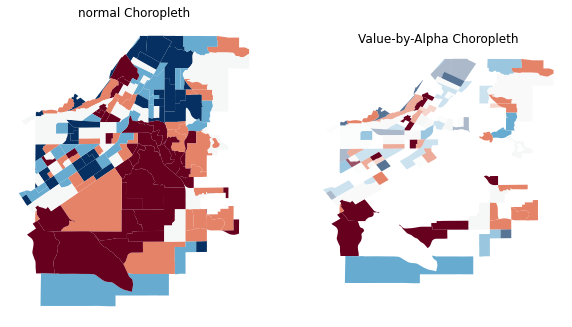

In [97]:
# Create new figure
fig, axs = plt.subplots(1,2, figsize=(10,10))

# use gdf.plot() to create regular choropleth
rusd_ej.plot(column='D_RESP_2', scheme='quantiles', cmap='RdBu', ax=axs[0])

# use vba_choropleth to create Value-by-Alpha Choropleth
vba_choropleth(x, y, rusd_ej, rgb_mapclassify=dict(classifier='quantiles'),
               alpha_mapclassify=dict(classifier='quantiles'),
               cmap='RdBu', ax=axs[1])

# set figure style
axs[0].set_title('normal Choropleth')
axs[0].set_axis_off()
axs[1].set_title('Value-by-Alpha Choropleth')

# plot
plt.show()

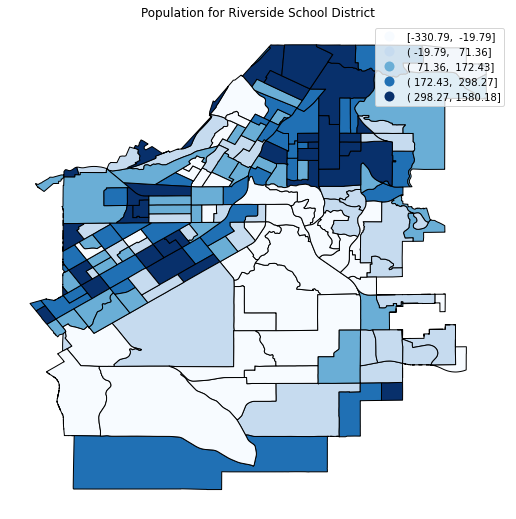

In [101]:

f, ax = plt.subplots(1, figsize=(9, 9))
rusd_ej.plot(ax=ax, column='D_RESP_2', legend=True, scheme='Quantiles',k=5,  \
         cmap='Blues', edgecolor='k')
ax.set_axis_off()
ax.set_title('Population for Riverside School District')
plt.axis('equal')
plt.show()

<AxesSubplot:xlabel='median_household_income', ylabel='D_RESP_2'>

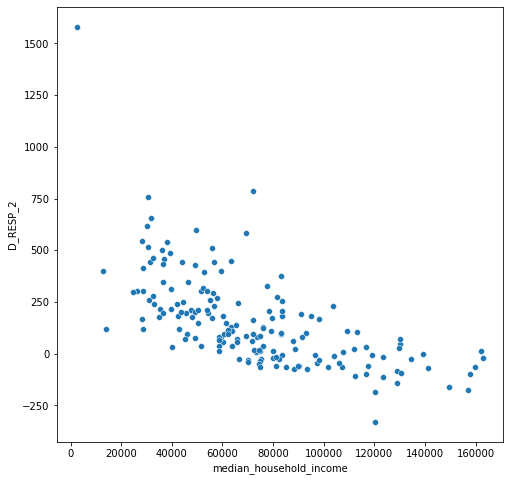

In [22]:
sns.scatterplot(data=rusd_ej, x="median_household_income", y="D_RESP_2")

<AxesSubplot:xlabel='median_household_income', ylabel='D_RESP_2'>

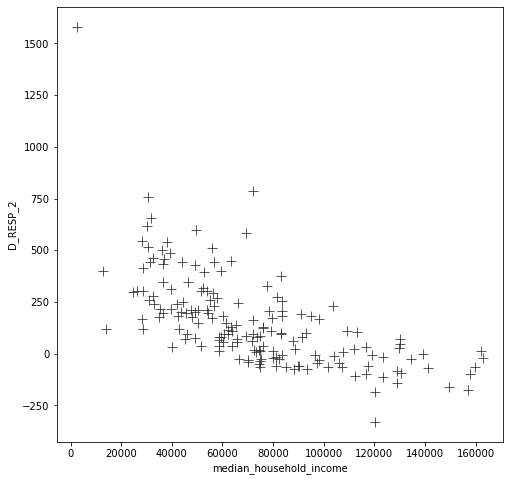

In [23]:
#sns.scatterplot(data=rusd_ej, x="median_household_income", y="D_RESP_2")
sns.scatterplot(data=rusd_ej, x="median_household_income", y="D_RESP_2", s=100, color=".2", marker="+")

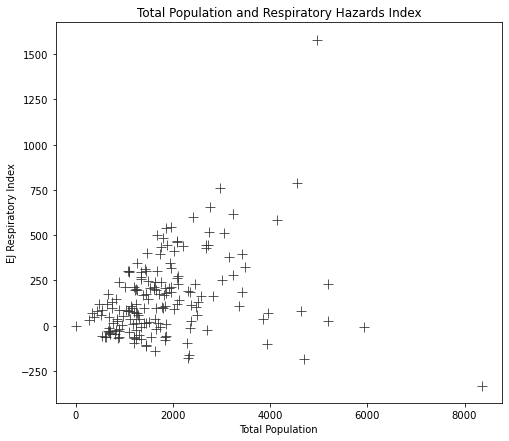

In [24]:
#sns.scatterplot(data=rusd_ej, x="median_household_income", y="D_RESP_2")
plt.figure(figsize=(8,7))
sns.scatterplot(data=rusd_ej, x="n_total_pop", y="D_RESP_2", s=100, color=".2", marker="+")
plt.title("Total Population and Respiratory Hazards Index") #title
plt.xlabel('Total Population') 
plt.ylabel('EJ Respiratory Index') 
plt.show()
#sns.scatterplot(data=rusd_ej, x="n_total_pop", y="D_RESP_2", s=100, color=".2", marker="+")

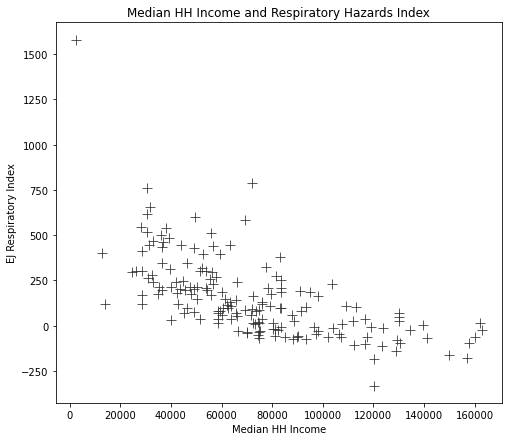

In [25]:

plt.figure(figsize=(8,7))
sns.scatterplot(data=rusd_ej, x="median_household_income", y="D_RESP_2", s=100, color=".2", marker="+")
plt.title("Median HH Income and Respiratory Hazards Index") #title
plt.xlabel('Median HH Income') 
plt.ylabel('EJ Respiratory Index') 
plt.show()

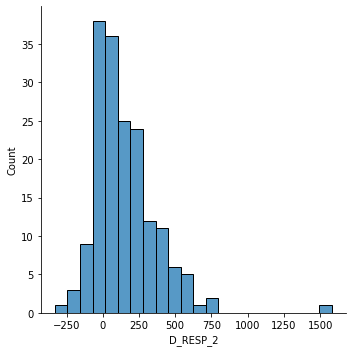

In [26]:
sns.displot(rusd_ej, x="D_RESP_2")

#### Subset data for Racial, Income and Respiratory Hazards Index for RUSD

<AxesSubplot:>

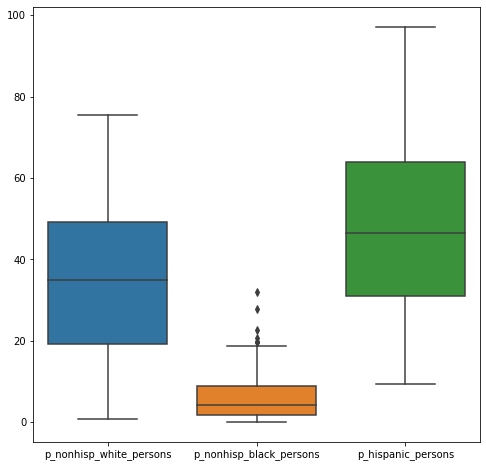

In [27]:
# Subset of racial and income variables within RUSD
_racial= rusd_ej[['p_nonhisp_white_persons','p_nonhisp_black_persons','p_hispanic_persons']]
sns.boxplot(data=_racial)


In [28]:
rusd_racial= rusd_ej[['D_RESP_2','p_nonhisp_white_persons','p_nonhisp_black_persons','p_hispanic_persons','median_household_income','geometry']]

In [29]:
rusd_racial.count()

D_RESP_2                   174
p_nonhisp_white_persons    173
p_nonhisp_black_persons    173
p_hispanic_persons         173
median_household_income    170
geometry                   174
dtype: int64

In [30]:
rusd_racial.describe()

,D_RESP_2,p_nonhisp_white_persons,p_nonhisp_black_persons,p_hispanic_persons,median_household_income
count,174.000000,173.000000,173.000000,173.000000,170.000000
mean,153.598136,35.399701,6.016479,49.286173,72603.635294
std,222.813592,18.835608,6.023301,21.162106,33534.156393
min,-330.789955,0.677201,0.000000,9.296482,2499.000000
25%,2.982630,19.141791,1.662050,31.037277,48200.750000
50%,105.536795,35.019973,4.269931,46.513995,69330.500000
75%,247.256274,49.215686,8.834688,63.959956,90180.500000
max,1580.176916,75.605214,31.886024,97.179044,162800.000000


### 4: Combine School Locations with School District/EJ Map

In [31]:
# Download NCES school location data 
schools = gpd.read_parquet("s3://spatial-ucr/nces/schools/schools_1819.parquet")
#schools.head()

In [32]:
# Download SEDA learning outcomes data
seda = pd.read_csv("https://stacks.stanford.edu/file/druid:db586ns4974/seda_school_pool_gcs_4.0.csv",converters={"sedasch":str})
seda.sedasch=seda.sedasch.str.rjust(12, "0")
#seda.head()

In [33]:
# Convert NCES data into a GeoDataFrame
school_geoms = schools[['NCESSCH','CNTY','NMCNTY', 'geometry']]
school_geoms.head()

,NCESSCH,CNTY,NMCNTY,geometry
0,010000500870,01095,Marshall County,POINT (-86.20617 34.26019)
1,010000500871,01095,Marshall County,POINT (-86.20488 34.26223)
2,010000500879,01095,Marshall County,POINT (-86.22014 34.27332)
3,010000500889,01095,Marshall County,POINT (-86.22181 34.25270)
4,010000501616,01095,Marshall County,POINT (-86.19329 34.28985)


In [34]:
# Merge SEDA and NCES data
seda_merge = seda.merge(school_geoms, left_on="sedasch", right_on= "NCESSCH")
#seda_merge.head()

In [35]:
# Convert merged NCES/SEDA data into a GeoDataFrame and plot it
seda_merge= gpd.GeoDataFrame(seda_merge)
#seda_merge.plot()

In [36]:
# Subset data to only locate schools in Riverside County 
riv_schools = seda_merge[seda_merge['CNTY']=='06065']
#riv_schools.plot()

In [37]:
# Subset school data to find schools in RUSD

rusd_schools = gpd.overlay(riv_schools, rusd, how='intersection')

In [38]:
rusd_schools.describe()

,fips,gradecenter,gap,tot_asmts,cellcount,mn_asmts,gcs_mn_avg_ol,gcs_mn_coh_ol,gcs_mn_grd_ol,gcs_mn_mth_ol,...,gcs_mn_avg_eb,gcs_mn_coh_eb,gcs_mn_grd_eb,gcs_mn_mth_eb,gcs_mn_avg_eb_se,gcs_mn_coh_eb_se,gcs_mn_grd_eb_se,gcs_mn_mth_eb_se,ALAND,AWATER
count,41.0,41.000000,41.0,41.000000,41.000000,41.000000,39.000000,38.000000,30.000000,37.000000,...,39.000000,38.000000,30.000000,37.000000,39.000000,38.000000,30.000000,37.000000,41.0,41.0
mean,6.0,5.219512,0.0,7398.414634,57.585366,154.419013,4.287896,0.015213,1.108461,-0.125453,...,4.291745,0.013039,1.097066,-0.107105,0.094226,0.026645,0.064230,0.150785,231195333.0,6617991.0
std,0.0,1.204413,0.0,3219.564085,21.718628,139.525939,1.780195,0.069924,0.155291,0.238337,...,1.762932,0.066472,0.138018,0.206136,0.058442,0.008506,0.006300,0.032630,0.0,0.0
min,6.0,4.500000,0.0,23.000000,4.000000,5.750000,0.813636,-0.154582,0.800438,-0.635549,...,0.677661,-0.147817,0.825864,-0.516014,0.066751,0.021463,0.060162,0.128271,231195333.0,6617991.0
25%,6.0,4.500000,0.0,6381.000000,38.000000,95.828571,3.227401,-0.027271,1.039046,-0.313761,...,3.231087,-0.026405,1.033912,-0.281745,0.068930,0.022126,0.061994,0.131901,231195333.0,6617991.0
50%,6.0,4.500000,0.0,7582.000000,71.000000,105.916667,3.731559,0.006878,1.131159,-0.119444,...,3.733712,0.005587,1.117078,-0.110054,0.070092,0.022523,0.062556,0.133917,231195333.0,6617991.0
75%,6.0,5.500000,0.0,8967.000000,72.000000,124.541667,5.227108,0.048769,1.181362,0.065561,...,5.227168,0.046460,1.169189,0.059956,0.100096,0.027356,0.063545,0.144563,231195333.0,6617991.0
max,6.0,7.500000,0.0,13609.000000,72.000000,523.423077,9.656434,0.206523,1.452442,0.417812,...,9.671492,0.190964,1.401099,0.330401,0.366315,0.057567,0.094338,0.226573,231195333.0,6617991.0


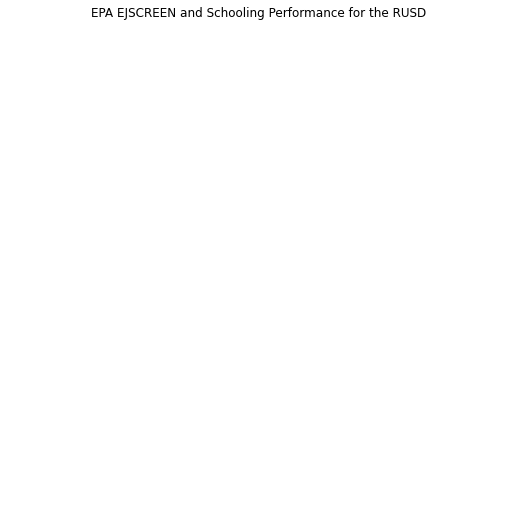

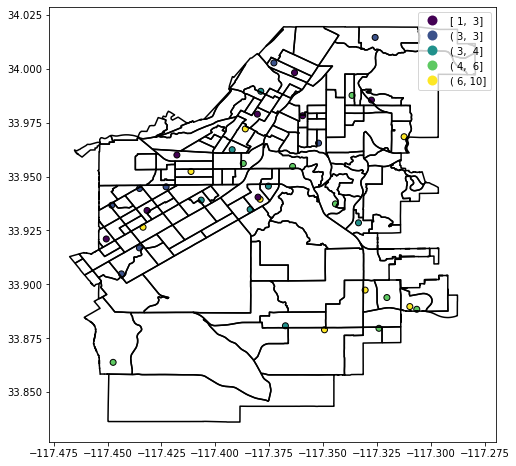

In [39]:
f, ax = plt.subplots( figsize=(9, 9))
#rusd_ej.plot(ax=ax, column='D_RESP_2', legend=True, scheme='Quantiles', k=6,legend_kwds={'fmt':'{:.0f}'},  \
         #cmap='RdYlBu', edgecolor='k')
#rusd_schools.plot(ax=ax, column='gcs_mn_avg_ol', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         #cmap='viridis', edgecolor='k')
base = rusd_ej.geometry.boundary.plot(edgecolor='black')
rusd_schools.plot(ax=base, column='gcs_mn_avg_ol', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='viridis', edgecolor='k')
ax.set_axis_off()
ax.set_title('EPA EJSCREEN and Schooling Performance for the RUSD')
plt.axis('equal')
plt.show()


### 5: Voronoi Polygons For School Performance and Respiratory Health Index

In [40]:
# Subset of rusd schools with only mean scores
rusd_pts= rusd_schools[['gcs_mn_avg_ol','geometry']]
rusd_pts.head()

,gcs_mn_avg_ol,geometry
0,8.098470,POINT (-117.30967 33.88970)
1,4.939048,POINT (-117.30644 33.88844)
2,3.253884,POINT (-117.43514 33.94446)
3,3.960433,POINT (-117.36408 33.95469)
4,3.599937,POINT (-117.37885 33.98955)


In [41]:
rusd_pts.describe()

,gcs_mn_avg_ol
count,39.000000
mean,4.287896
std,1.780195
min,0.813636
25%,3.227401
50%,3.731559
75%,5.227108
max,9.656434


<AxesSubplot:>

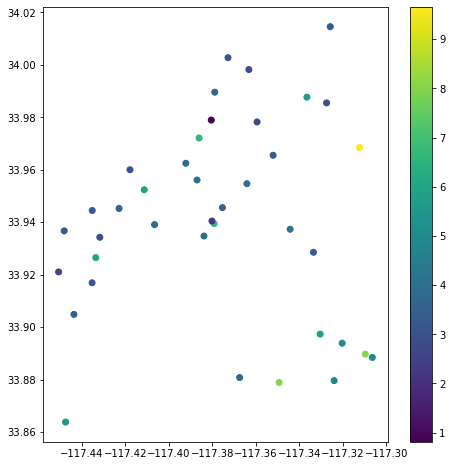

In [42]:
rusd_pts.plot(column='gcs_mn_avg_ol', legend=True)

In [43]:
# Subset for EJ screen for RUSD only containing Respiratory index and geometry

EJ_RUSD= rusd_ej[['D_RESP_2','geometry']]
#EJ_RUSD.plot(column='D_RESP_2', cmap='Greens', scheme='Quantiles', k=3,edgecolor='grey',
        #legend=True)

### 5.1 Overlays - Two Approaches 

#### 5.1a Approach 1 Spatial Join

<AxesSubplot:>

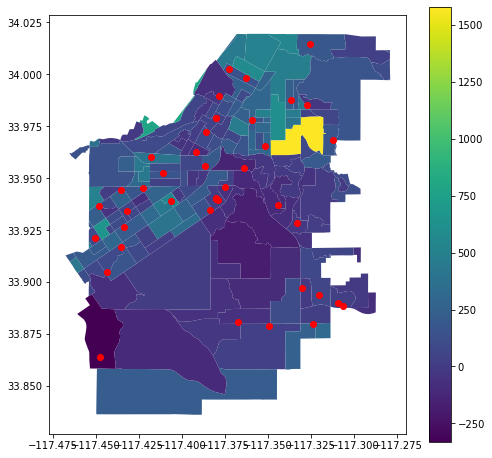

In [44]:
# 1 for 1 mapping
base  = EJ_RUSD.plot(column='D_RESP_2', legend=True)
rusd_pts.plot(color='red', ax=base)

In [45]:
rusd_sch= gpd.sjoin(rusd_pts, EJ_RUSD, how='left', op='within')
rusd_sch.head()

,gcs_mn_avg_ol,geometry,index_right,D_RESP_2
0,8.098470,POINT (-117.30967 33.88970),135,23.698113
1,4.939048,POINT (-117.30644 33.88844),135,23.698113
2,3.253884,POINT (-117.43514 33.94446),85,261.324237
3,3.960433,POINT (-117.36408 33.95469),36,-142.849901
4,3.599937,POINT (-117.37885 33.98955),6,-62.781118


In [46]:
rusd_pts['D_RESP_2a'] = rusd_sch.D_RESP_2
rusd_pts.head()

/opt/tljh/user/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,gcs_mn_avg_ol,geometry,D_RESP_2a
0,8.098470,POINT (-117.30967 33.88970),23.698113
1,4.939048,POINT (-117.30644 33.88844),23.698113
2,3.253884,POINT (-117.43514 33.94446),261.324237
3,3.960433,POINT (-117.36408 33.95469),-142.849901
4,3.599937,POINT (-117.37885 33.98955),-62.781118


In [47]:
# rusd_pts.crs

#### 5.1b. Approach 2 Areal Interpolation

In [48]:
x = rusd_pts.geometry.x
y = rusd_pts.geometry.y
cents = np.array([x,y]).T
# cents

In [49]:
schools_polygons, school_cents = lps.cg.voronoi_frames(cents)
# Schools_vd has polygons geometry
# school_cents has points geometry

In [50]:
school_cents.head()


,geometry
0,POINT (-117.30967 33.88970)
1,POINT (-117.30644 33.88844)
2,POINT (-117.43514 33.94446)
3,POINT (-117.36408 33.95469)
4,POINT (-117.37885 33.98955)


<AxesSubplot:>

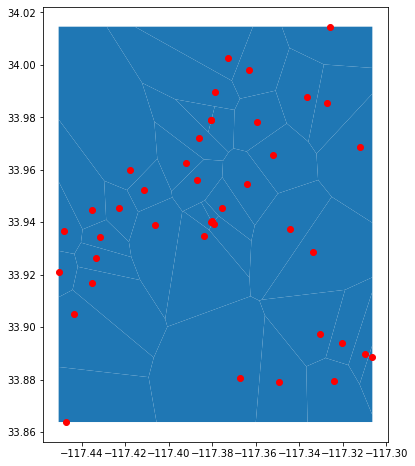

In [51]:
base = schools_polygons.plot()
rusd_pts.plot(ax=base, color='red')

In [52]:
# EJ_RUSD.crs

<AxesSubplot:>

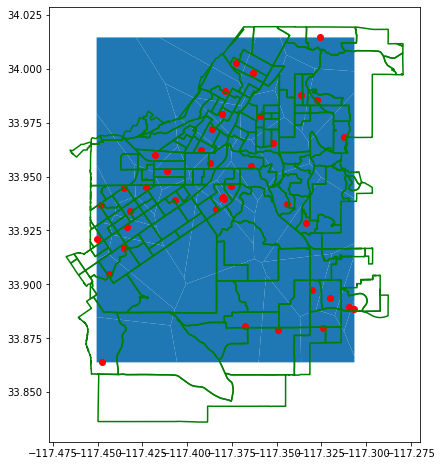

In [53]:
base = EJ_RUSD.geometry.boundary.plot(edgecolor='green')
schools_polygons.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

In [54]:
schools_polygons, school_cents = lps.cg.voronoi_frames(cents, clip = EJ_RUSD.unary_union)

In [55]:
#schools_polygons.to_crs?

In [56]:
# School_Polygons had no crs here we are setting it equal to EJ_RUSD
schools_polygons.crs = EJ_RUSD.crs

In [57]:
# We need to set a crs for all the datasets
schools_polygons = schools_polygons.to_crs("EPSG:3395")
EJ_RUSD = EJ_RUSD.to_crs("EPSG:3395")
rusd_pts = rusd_pts.to_crs("EPSG:3395")

<AxesSubplot:>

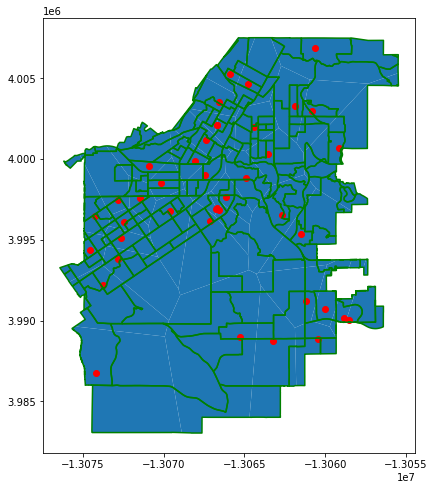

In [58]:
base = EJ_RUSD.geometry.boundary.plot(edgecolor='green')
schools_polygons.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

<AxesSubplot:>

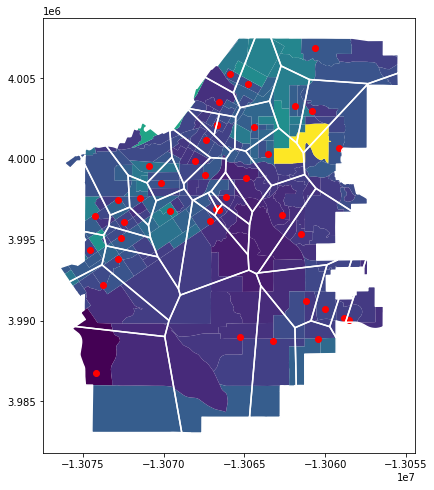

In [59]:
# overlay schools, RUSD repsiratory index and voronoi polygons
base = EJ_RUSD.plot(column='D_RESP_2')
schools_polygons.geometry.boundary.plot(ax=base, edgecolor='white') # these are the voronoi polygons
rusd_pts.plot(ax=base, color='red')

Estimate the EJ_respiratory hazards for a school using areal interpolation

In [60]:
#type(schools_polygons)

In [61]:
# schools_polygons.dtypes

In [62]:
RESP = tob.area_weighted.area_interpolate(source_df=EJ_RUSD,
                                           target_df=schools_polygons,
                                           intensive_variables=['D_RESP_2'])

In [63]:
RESP.head()

,D_RESP_2,geometry
0,20.450107,"MULTIPOLYGON (((-13057470.389 3993779.175, -13..."
1,-17.811262,"MULTIPOLYGON (((-13058738.935 3989890.951, -13..."
2,164.343134,"POLYGON ((-13072106.540 3997019.611, -13073314..."
3,-53.597176,"POLYGON ((-13065845.141 4000452.602, -13065598..."
4,46.859300,"POLYGON ((-13067444.923 4005075.853, -13065684..."


<AxesSubplot:>

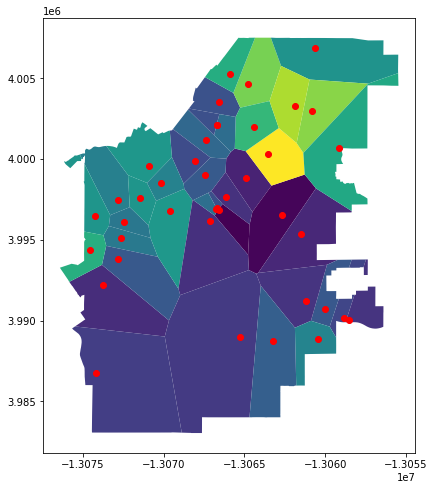

In [64]:
base = RESP.plot(column='D_RESP_2')
rusd_pts.plot(ax=base, color='red')

In [65]:
rusd_pts['D_RESP_2b'] = RESP.D_RESP_2
rusd_pts.head()

,gcs_mn_avg_ol,geometry,D_RESP_2a,D_RESP_2b
0,8.098470,POINT (-13058852.952 3990176.444),23.698113,20.450107
1,4.939048,POINT (-13058493.613 3990007.858),23.698113,-17.811262
2,3.253884,POINT (-13072820.209 3997488.544),261.324237,164.343134
3,3.960433,POINT (-13064910.068 3998854.898),-142.849901,-53.597176
4,3.599937,POINT (-13066553.478 4003513.021),-62.781118,46.859300


<AxesSubplot:xlabel='D_RESP_2a', ylabel='D_RESP_2b'>

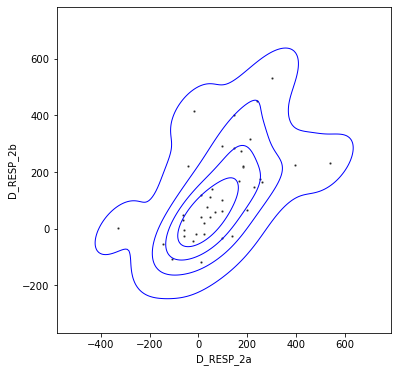

In [66]:
import seaborn as sns
f, ax = plt.subplots(figsize=(6, 6))
x='D_RESP_2a'
y='D_RESP_2b'
sns.scatterplot(x=x, y=y, s=5, color=".15", data=rusd_pts)
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako", data=rusd_pts)
sns.kdeplot(x=x, y=y, levels=5, color="b", linewidths=1, data=rusd_pts)

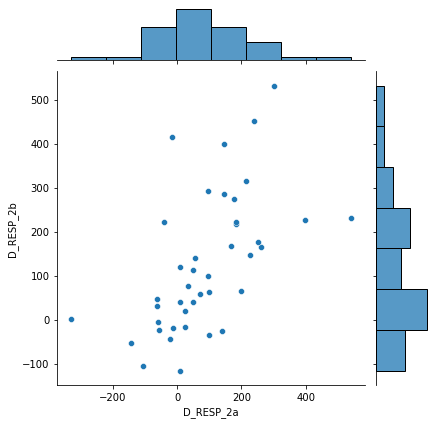

In [67]:
sns.jointplot(data=rusd_pts, x="D_RESP_2a", y="D_RESP_2b")

#### Note: The two indices are positively correlated

In [68]:
# scatter plot for the two indices, D_RESP_2a is based on 1 to 1 relationship between schools and their location
# D_RESP_2b we obtained from voronoi interpolation
# sns.scatterplot(data=rusd_pts, x="D_RESP_2a", y="D_RESP_2b", alpha=0.5)

In [69]:
# subsetting the data set to contain the two indices
EJ_new= rusd_pts[['D_RESP_2a','D_RESP_2b']]


<AxesSubplot:>

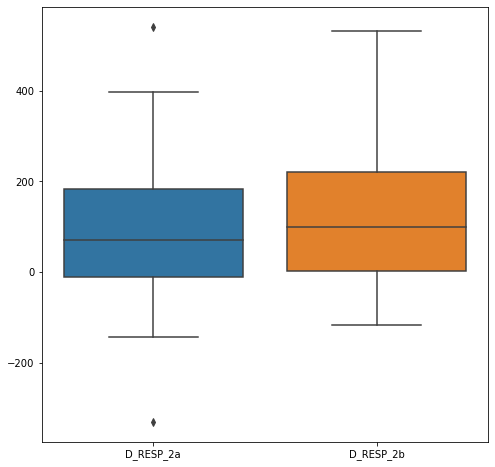

In [70]:
# the values of the two indices differ as seen by the boxplot
sns.boxplot(data=EJ_new)

#### 6. Checking Association between Schooling Outcome and EJ Respiratory Hazards Index

In [71]:
EJ_sch= rusd_pts[['gcs_mn_avg_ol','D_RESP_2a','D_RESP_2b']]

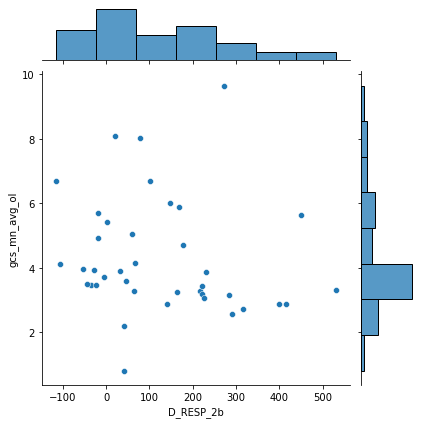

In [72]:
sns.jointplot(data=EJ_sch, x="D_RESP_2b", y="gcs_mn_avg_ol")

In [73]:
#sns.relplot(data=EJ_sch, x="gcs_mn_avg_ol", y="D_RESP_2a")
#sns.rugplot(data=EJ_sch, x="gcs_mn_avg_ol", y="D_RESP_2a")

In [74]:
# sns.pairplot(EJ_sch)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(19680801)

data = usd_pts
data['b'] = data['a'] + 10 * np.random.randn(50)
data['d'] = np.abs(data['d']) * 100

fig, ax = plt.subplots()
ax.scatter('a', 'b', c='c', s='d', data=data)
ax.set(xlabel='entry a', ylabel='entry b')
plt.show()

NameError: name 'usd_pts' is not defined

In [ ]:
# mapping areal interpolation EJ respiratory Index
# Based on the 1 to 1 assocation - We are using the original EJ Repsiratory Hazards Index
sns.scatterplot(data=rusd_pts, x="D_RESP_2a", y="gcs_mn_avg_ol")
sns.regplot(data=rusd_pts, x='D_RESP_2a', y='gcs_mn_avg_ol')

# Based on the areal interpolation - We are using the new EJ Repsiratory Hazards Index
sns.scatterplot(data=rusd_pts, x="D_RESP_2b", y="gcs_mn_avg_ol")
sns.regplot(data=rusd_pts, x='D_RESP_2b', y='gcs_mn_avg_ol')


In [ ]:
import statsmodels.api as sm 
import pandas
from patsy import dmatrices

vars = rusd_pts[['D_RESP_2a', 'D_RESP_2b', 'gcs_mn_avg_ol']]
vars.head()

In [ ]:
# Basic OLS Regression to Test for linear relationship between EJ index and School Performance
#y, X = dmatrices('gcs_mn_avg_ol ~ D_RESP_2a + D_RESP_2b', data=vars, return_type='dataframe')
#mod = sm.OLS(y, X) # create a model object
#res = mod.fit() # fit the model
#print(res.summary()) # Summarize the model

### Adding Racial Composition 

In [ ]:
# Resetting the crs
rusd_racial = rusd_racial.to_crs("EPSG:3395")

In [ ]:
base = rusd_racial.plot(column='p_nonhisp_black_persons', scheme='Quantiles', k=5, legend=True)
rusd_pts.plot(ax=base, color='red')

In [ ]:
# White Race
base = rusd_racial.geometry.boundary.plot(edgecolor='white')
schools_polygons.plot(ax=base)
rusd_pts.plot(ax=base, color='red')

### Voronoi On Racial Composition

#### Approach 1 spatial join

In [ ]:
# Checking for NAN values
rusd_racial.p_nonhisp_black_persons.unique

In [ ]:
p_nonhisp_black_persons =  rusd_racial.p_nonhisp_black_persons
rusd_racial.p_nonhisp_black_persons = p_nonhisp_black_persons.replace(to_replace= 'NaN', value=np.nan).astype(float)

In [ ]:
p_nonhisp_white_persons =  rusd_racial.p_nonhisp_white_persons
rusd_racial.p_nonhisp_white_persons = p_nonhisp_white_persons.replace(to_replace= 'NaN', value=np.nan).astype(float)

In [ ]:
p_hispanic_persons =  rusd_racial.p_hispanic_persons
rusd_racial.p_hispanic_persons = p_hispanic_persons.replace(to_replace= 'NaN', value=np.nan).astype(float)

In [ ]:
racial_comp = gpd.sjoin(rusd_pts, rusd_racial, how='left', op='within')
racial_comp.head()

In [ ]:
# percentage nohispanic blacks
schools_polygons['racial_comp'] = racial_comp.p_nonhisp_black_persons
rusd_pts['racial_comp'] = racial_comp.p_nonhisp_black_persons

In [ ]:
base = schools_polygons.plot(column='racial_comp')
rusd_pts.plot(ax=base, color='red')

#### Approach 2 areal interpolation

In [ ]:
results = tob.area_weighted.area_interpolate(source_df=rusd_racial,
                                           target_df=schools_polygons,
                                           intensive_variables=['p_nonhisp_white_persons', 'p_nonhisp_black_persons','p_hispanic_persons'])   

In [ ]:
results.head()

In [ ]:
racial_comp['pctblack'] = results.p_nonhisp_black_persons
racial_comp['pctwh'] = results.p_nonhisp_white_persons
racial_comp['pcthisp'] = results.p_hispanic_persons

In [ ]:
racial_comp.head()

In [ ]:
#Racial_old= racial_comp[['p_nonhisp_black_persons','p_nonhisp_white_persons','p_hispanic_persons']]
#sns.boxplot(data=Racial_old)
Racial_new= racial_comp[['pctblack','pctwh','pcthisp']]
sns.boxplot(data=Racial_new)

In [ ]:
sns.scatterplot(data=racial_comp, x="pctblack", y="gcs_mn_avg_ol")
sns.regplot(data=racial_comp, x='pctblack', y='gcs_mn_avg_ol')

In [ ]:
DF = racial_comp[['gcs_mn_avg_ol','pctblack','pctwh','pcthisp']]

In [ ]:
sns.jointplot(data=DF, x='pctblack', y='gcs_mn_avg_ol', hue="species",
    kind="kde")

In [ ]:
sns.scatterplot(data=racial_comp, x="pctwh", y="gcs_mn_avg_ol")
#sns.regplot(data=racial_comp, x='pctwh', y='gcs_mn_avg_ol')
#sns.scatterplot(data=racial_comp, x="pcthisp", y="gcs_mn_avg_ol")
#sns.scatterplot(data=racial_comp, x="pctblack", y="gcs_mn_avg_ol")
#sns.regplot(data=racial_comp, x='pctblack', y='gcs_mn_avg_ol')

In [ ]:
# Checking for Not a number (NAN)
racial_comp.median_household_income.unique

In [ ]:
racial_comp.info()

In [ ]:
new_results = tob.area_weighted.area_interpolate(source_df=rusd_racial,
                                           target_df=schools_polygons,
                                           intensive_variables=['median_household_income'])   

In [ ]:
new_results.head()

In [ ]:
racial_comp['income'] = new_results.median_household_income

In [ ]:
racial_comp.head()

In [ ]:
income_new= racial_comp[['income','median_household_income']]
sns.boxplot(data=income_new)